# Neural Image Testing

The purpose of this notebook is to test whether we are able to produce a neural image based soley on the firing rates of the neurons in a mouse's visual cortex.

https://observatory.brain-map.org/visualcoding/stimulus/static_gratings 

In [1]:
import torch
import numpy as np
import pandas as pd
import psutil
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("CUDA GPU is available.")
    device = torch.device('cuda')
else:
    print("CUDA GPU is not available. Using CPU instead.")
    device = torch.device('cpu')
    
print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Total RAM: {(psutil.virtual_memory().total / (1024**3)):.2f} GB")
print(f"Available RAM: {(psutil.virtual_memory().available / (1024**3)):.2f} GB")

CUDA GPU is available.
Current GPU device: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Total RAM: 1006.94 GB
Available RAM: 943.89 GB


## 0) Load Pre-Processed Data

In [2]:
filtered_normalized_pickle = 'filtered_normalized_pickle_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(filtered_normalized_pickle, 'rb') as f:
    filtered_normalized_firing_rates = pickle.load(f)

filtered_normalized_firing_rates

,frame,950907205,950907518,950907524,950907209,950907528,950907526,950907214,950907216,950907211,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,92.0,1.253388,-0.098398,-0.681226,-0.097059,-0.031769,4.108841,-0.522021,-1.042585,-0.074797,...,1.087432,-0.340714,0.321338,-0.438852,0.834920,-0.531743,-0.172733,-0.556999,-0.508071,-0.298960
1,114.0,-1.394929,-0.098398,-0.681226,-0.097059,-0.031769,-0.311265,-0.522021,-1.042585,-0.074797,...,-0.558516,-0.340714,0.857953,-0.438852,-0.770436,-0.531743,-0.172733,0.990401,-0.508071,-0.298960
2,114.0,-0.865265,-0.098398,-0.681226,-0.097059,-0.031769,1.898788,0.243953,-1.042585,-0.074797,...,-0.558516,-0.340714,-0.215278,-0.438852,-0.770436,-0.531743,-0.172733,0.603551,-0.508071,-0.298960
3,0.0,-0.865265,-0.098398,0.909549,-0.097059,-0.031769,4.108841,3.307852,-1.042585,-0.074797,...,-0.558516,-0.340714,-0.751893,-0.438852,0.032242,0.540393,-0.172733,0.603551,1.118083,-0.298960
4,37.0,-0.335602,-0.098398,0.909549,-0.097059,-0.031769,4.108841,0.243953,0.008123,12.640684,...,-0.558516,0.565116,-0.215278,1.150418,0.032242,-0.531743,-0.172733,-0.943849,-0.508071,-0.298960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,15.0,0.194062,-0.098398,-0.681226,-0.097059,-0.031769,-0.311265,0.243953,-0.517231,-0.074797,...,1.087432,-0.340714,1.394569,-0.438852,-0.770436,2.684665,-0.172733,-0.170149,-0.508071,-0.298960
5946,46.0,-0.865265,-0.098398,0.909549,-0.097059,-0.031769,-0.311265,-0.522021,-1.042585,-0.074797,...,0.264458,-0.340714,0.321338,-0.438852,-0.770436,-0.531743,-0.172733,0.216701,-0.508071,-0.298960
5947,86.0,0.194062,-0.098398,0.909549,-0.097059,-0.031769,-0.311265,0.243953,0.008123,-0.074797,...,1.910406,-0.340714,0.321338,-0.438852,0.032242,-0.531743,-0.172733,0.990401,-0.508071,-0.298960
5948,110.0,1.253388,-0.098398,-0.681226,-0.097059,-0.031769,-0.311265,1.009928,1.058832,-0.074797,...,1.087432,-0.340714,-0.751893,1.150418,0.032242,-0.531743,-0.172733,-0.556999,-0.508071,1.380747


In [3]:
# Load the dictionary of valid spike times from the pickle.
with open('gratings_spikes_721123822.pkl', 'rb') as f:
    gratings_spikes = pickle.load(f)
    
# Get the columns that are common between both DataFrames
common_columns = set(gratings_spikes.columns).intersection(set(filtered_normalized_firing_rates.columns))

# Drop columns in gratings_spikes that are not in filtered_normalized_firing_rates
columns_to_drop = set(gratings_spikes.columns) - common_columns
gratings_spikes.drop(columns=columns_to_drop, inplace=True)
    
gratings_spikes

,950907205,950907518,950907524,950907209,950907528,950907526,950907214,950907216,950907211,950907220,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,6,0,0,0,0,0,3,0,0,0,...,2,0,0,2,1,0,0,6,0,0
1,3,0,0,0,0,2,3,2,0,2,...,5,0,3,0,3,1,0,7,1,0
2,2,0,1,0,0,0,2,1,0,2,...,2,0,0,0,1,1,0,4,0,0
3,2,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,2,0,0
4,4,0,1,0,0,0,2,0,0,1,...,2,0,0,0,3,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,6,0,0,0,0,0,3,2,0,0,...,0,2,1,0,3,4,0,1,4,0
5800,5,0,0,0,0,1,1,0,0,3,...,0,0,0,0,1,0,0,2,1,0
5801,2,0,0,0,0,0,2,2,0,1,...,0,0,0,0,0,3,0,3,0,0
5802,1,0,1,0,0,0,2,0,0,2,...,0,0,0,0,2,1,0,6,2,0


In [4]:
# Load the dictionary of valid spike times from the pickle.
with open('grayscale_df_721123822.pkl', 'rb') as f:
    grayscale_df = pickle.load(f)
    
grayscale_df

,0,1,2,3,4,5,6,7,8,9,...,62490,62491,62492,62493,62494,62495,62496,62497,62498,62499
0,0.545311,0.291453,-0.797751,0.399514,0.451715,-0.790764,0.233199,0.588779,-0.743167,0.054909,...,0.792230,-0.242836,-0.581899,0.746844,-0.064974,-0.690567,0.663104,0.116224,-0.763770,0.545311
1,-0.767250,-0.787380,-0.798119,-0.799338,-0.791025,-0.773276,-0.746305,-0.710433,-0.666087,-0.613797,...,0.555215,0.489097,0.417145,0.340217,0.259232,0.175155,0.088989,0.001761,-0.085487,-0.171716
2,-0.583465,-0.688246,-0.760291,-0.796172,-0.794183,-0.754418,-0.678768,-0.570833,-0.435745,-0.279931,...,-0.113631,0.060749,0.232239,0.392683,0.534448,0.650792,0.736181,0.786553,0.799512,0.774442
3,0.700738,0.767747,0.798237,0.790760,0.745669,0.665110,0.552914,0.414419,0.256212,0.085818,...,-0.085818,-0.256212,-0.414419,-0.552914,-0.665110,-0.745669,-0.790760,-0.798237,-0.767747,-0.700738
4,0.774442,0.743044,0.699834,0.645498,0.580900,0.507068,0.425175,0.336522,0.242520,0.144662,...,0.250265,0.152661,0.052630,-0.048237,-0.148338,-0.246080,-0.339910,-0.428337,-0.509954,-0.583465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,0.549340,0.251536,-0.093557,-0.421061,-0.669406,-0.791902,-0.765521,-0.595222,-0.313021,0.028028,...,0.358708,0.627664,0.778619,0.783193,0.640527,0.377442,0.043398,-0.298805,-0.584832,-0.760912
5800,0.203271,0.390013,0.552052,0.679127,0.763187,0.798910,0.784033,0.719497,0.609391,0.460688,...,0.619812,0.473902,0.297977,0.103179,-0.098154,-0.293271,-0.469813,-0.616598,-0.724330,-0.786185
5801,0.475206,-0.717343,-0.221963,0.795702,-0.058943,-0.774894,0.332503,0.657511,-0.564623,-0.458183,...,0.716499,0.223791,-0.795503,0.057045,0.775365,-0.330771,-0.658593,0.563273,0.459742,-0.725575
5802,0.301211,-0.782660,-0.024910,0.791454,-0.254496,-0.701609,0.502184,0.524324,-0.687285,-0.281693,...,0.782263,0.026812,-0.791729,0.252691,0.702522,-0.500701,-0.525760,0.686309,0.283473,-0.786383


## 1) Import and Process Data

In [ ]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache 

# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

# Display session keys
session_keys = []
print("Session keys:")
for session_key in session_table.index:
    session_keys.append(session_key)
print(session_keys)
 
session_number = 721123822

# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times

# Get stimulus tables.
natural_scenes = session.get_stimulus_table("natural_scenes")
gratings_images = session.get_stimulus_table("static_gratings")
gratings_images.reset_index(drop=True, inplace=True)

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

In [6]:
session.stimulus_names

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [7]:
# Access the invalid_times DataFrame
invalid_times = session.invalid_times

# Function to check if a spike time is valid
def is_valid_time(spike_times, invalid_intervals):
    invalid = np.zeros_like(spike_times, dtype=bool)
    for _, row in invalid_intervals.iterrows():
        start, end = row['start_time'], row['stop_time']
        invalid |= (spike_times >= start) & (spike_times <= end)
    return ~invalid

# Filter the valid spike times
valid_spike_times = {}
with tqdm(total=len(spike_times), desc='Filtering valid spike times') as pbar:
    for neuron, times in spike_times.items():
        valid_mask = is_valid_time(times, session.invalid_times)
        valid_spike_times[neuron] = times[valid_mask]
        pbar.update(1)

Filtering valid spike times: 100%|██████████| 1191/1191 [00:00<00:00, 1575.25it/s]


In [5]:
import concurrent.futures

# Parameters
timesteps_per_frame = 1  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = gratings_images

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

gratings_spikes = spike_dataframe.T

gratings_spikes

Processing neurons: 100%|██████████| 1191/1191 [05:36<00:00,  3.54it/s]


,950907203,950907205,950907518,950907524,950907209,950907207,950907528,950907526,950907214,950907216,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,1,6,0,0,0,0,0,0,3,0,...,2,0,0,2,1,0,0,6,0,0
1,0,3,0,0,0,0,0,2,3,2,...,5,0,3,0,3,1,0,7,1,0
2,0,2,0,1,0,0,0,0,2,1,...,2,0,0,0,1,1,0,4,0,0
3,0,2,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,2,0,0
4,1,4,0,1,0,0,0,0,2,0,...,2,0,0,0,3,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,6,0,0,0,0,0,0,3,2,...,0,2,1,0,3,4,0,1,4,0
5996,0,5,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,2,1,0
5997,2,2,0,0,0,0,0,0,2,2,...,0,0,0,0,0,3,0,3,0,0
5998,1,1,0,1,0,0,0,0,2,0,...,0,0,0,0,2,1,0,6,2,0


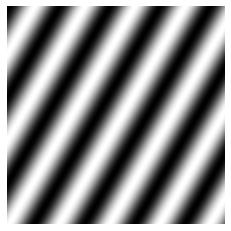

In [28]:
def generate_grating(contrast, orientation, phase, size, spatial_frequency):
    """
    Generate a static grating image based on the given parameters.
    """
    # Create a meshgrid for the x and y coordinates
    x, y = np.meshgrid(np.linspace(-size[0]/2, size[0]/2, int(size[0])), 
                       np.linspace(-size[1]/2, size[1]/2, int(size[1])))
    
    # Convert orientation to radians
    theta = np.deg2rad(orientation)
    
    # Generate the grating
    grating = contrast * np.sin(2 * np.pi * spatial_frequency * (x * np.cos(theta) + y * np.sin(theta)) + phase)
    
    return grating  # Corrected this line

# Example usage
contrast = 0.8
orientation = 30.0  # in degrees
phase = 0.75  # in radians
size = [250.0, 250.0]  # in pixels
spatial_frequency = 0.02  # in cycles/pixel

grating = generate_grating(contrast, orientation, phase, size, spatial_frequency)

# Display the grating
plt.imshow(grating, cmap='gray')
plt.axis('off')
plt.show()

In [34]:
import pandas as pd
import numpy as np

# Initialize an empty list to store the flattened grayscale arrays
grayscale_arrays = []

# Initialize an empty list to store skipped rows
skipped_rows = []

# Filter out rows from gratings_spikes that should be skipped
gratings_spikes = gratings_spikes.loc[~gratings_spikes.index.isin(skipped_rows)]

# Loop through each row in the stimulus_table DataFrame
for index, row in grating_images.iterrows():
    # Convert the variables to appropriate types
    contrast = float(row['contrast']) if row['contrast'] != 'null' else None
    orientation = float(row['orientation']) if row['orientation'] != 'null' else None
    phase = float(row['phase']) if row['phase'] != 'null' else None
    spatial_frequency = float(row['spatial_frequency']) if row['spatial_frequency'] != 'null' else None
    
    # Convert the size to a list of floats
    size = [float(x) for x in row['size'].strip('[]').split(',')] if row['size'] != 'null' else None
    
    # Check if any of the variables is None and skip the iteration
    if None in [contrast, orientation, phase, size, spatial_frequency]:
        skipped_rows.append(index)
        continue
    
    # Generate the grating
    grating = generate_grating(contrast, orientation, phase, size, spatial_frequency)
    
    # Check the shape of the grating
    if grating.shape != (250, 250):
        print(f"Warning: Unexpected shape {grating.shape} at index {index}")
        continue
    
    # Flatten the grating
    grating_flat = grating.flatten()
    
    # Append the 1D array to the list
    grayscale_arrays.append(grating_flat)

# Convert the list of 1D arrays to a DataFrame
grayscale_df = pd.DataFrame(grayscale_arrays)
# Drop the skipped rows from gratings_spikes
gratings_spikes = gratings_spikes.drop(skipped_rows, errors='ignore')
# Trim the DataFrame to only have 59500 rows
gratings_spikes = gratings_spikes.iloc[:59500]

# Print the shape of the DataFrame to debug
print("Shape of grayscale_df:", grayscale_df.shape)
print("Shape of gratings_spikes:", gratings_spikes.shape)

Shape of grayscale_df: (5804, 62500)
Shape of gratings_spikes: (5804, 1191)


In [40]:
grayscale_df.to_pickle('grayscale_df_721123822.pkl')
grayscale_df

,0,1,2,3,4,5,6,7,8,9,...,62490,62491,62492,62493,62494,62495,62496,62497,62498,62499
0,0.545311,0.291453,-0.797751,0.399514,0.451715,-0.790764,0.233199,0.588779,-0.743167,0.054909,...,0.792230,-0.242836,-0.581899,0.746844,-0.064974,-0.690567,0.663104,0.116224,-0.763770,0.545311
1,-0.767250,-0.787380,-0.798119,-0.799338,-0.791025,-0.773276,-0.746305,-0.710433,-0.666087,-0.613797,...,0.555215,0.489097,0.417145,0.340217,0.259232,0.175155,0.088989,0.001761,-0.085487,-0.171716
2,-0.583465,-0.688246,-0.760291,-0.796172,-0.794183,-0.754418,-0.678768,-0.570833,-0.435745,-0.279931,...,-0.113631,0.060749,0.232239,0.392683,0.534448,0.650792,0.736181,0.786553,0.799512,0.774442
3,0.700738,0.767747,0.798237,0.790760,0.745669,0.665110,0.552914,0.414419,0.256212,0.085818,...,-0.085818,-0.256212,-0.414419,-0.552914,-0.665110,-0.745669,-0.790760,-0.798237,-0.767747,-0.700738
4,0.774442,0.743044,0.699834,0.645498,0.580900,0.507068,0.425175,0.336522,0.242520,0.144662,...,0.250265,0.152661,0.052630,-0.048237,-0.148338,-0.246080,-0.339910,-0.428337,-0.509954,-0.583465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,0.549340,0.251536,-0.093557,-0.421061,-0.669406,-0.791902,-0.765521,-0.595222,-0.313021,0.028028,...,0.358708,0.627664,0.778619,0.783193,0.640527,0.377442,0.043398,-0.298805,-0.584832,-0.760912
5800,0.203271,0.390013,0.552052,0.679127,0.763187,0.798910,0.784033,0.719497,0.609391,0.460688,...,0.619812,0.473902,0.297977,0.103179,-0.098154,-0.293271,-0.469813,-0.616598,-0.724330,-0.786185
5801,0.475206,-0.717343,-0.221963,0.795702,-0.058943,-0.774894,0.332503,0.657511,-0.564623,-0.458183,...,0.716499,0.223791,-0.795503,0.057045,0.775365,-0.330771,-0.658593,0.563273,0.459742,-0.725575
5802,0.301211,-0.782660,-0.024910,0.791454,-0.254496,-0.701609,0.502184,0.524324,-0.687285,-0.281693,...,0.782263,0.026812,-0.791729,0.252691,0.702522,-0.500701,-0.525760,0.686309,0.283473,-0.786383


In [41]:
gratings_spikes.to_pickle('gratings_spikes_721123822.pkl')
gratings_spikes

,950907203,950907205,950907518,950907524,950907209,950907207,950907528,950907526,950907214,950907216,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,1,6,0,0,0,0,0,0,3,0,...,2,0,0,2,1,0,0,6,0,0
1,0,3,0,0,0,0,0,2,3,2,...,5,0,3,0,3,1,0,7,1,0
2,0,2,0,1,0,0,0,0,2,1,...,2,0,0,0,1,1,0,4,0,0
3,0,2,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,2,0,0
4,1,4,0,1,0,0,0,0,2,0,...,2,0,0,0,3,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,1,6,0,0,0,0,0,0,3,2,...,0,2,1,0,3,4,0,1,4,0
5800,0,5,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,2,1,0
5801,2,2,0,0,0,0,0,0,2,2,...,0,0,0,0,0,3,0,3,0,0
5802,1,1,0,1,0,0,0,0,2,0,...,0,0,0,0,2,1,0,6,2,0


## 2. Create Neural Images using only gratings.

In [20]:
R_it = grayscale_df
S_tp = gratings_spikes

# Convert Pandas DataFrames to PyTorch tensors
R_it_tensor = torch.tensor(R_it.values, dtype=torch.float32)
S_tp_tensor = torch.tensor(S_tp.values, dtype=torch.float32)

# Transpose R_it
R_it_tensor_T = R_it_tensor.T

# Perform matrix multiplication
PS_ip_tensor = torch.mm(R_it_tensor_T, S_tp_tensor)

# Convert the result back to a Pandas DataFrame if needed
PS_ip_df = pd.DataFrame(PS_ip_tensor.numpy())

PS_ip_df

,0,1,2,3,4,5,6,7,8,9,...,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170
0,1307.900269,-4.993250,185.807571,3.407486,-0.276463,44.514275,979.371216,780.012146,7.844075,506.964508,...,167.931534,-20.507051,-29.368931,199.034744,355.440765,156.532379,49.918617,1722.076782,88.307594,45.704906
1,2001.538086,-5.158870,251.348358,7.951730,-1.049664,73.986916,1471.732544,1180.385864,6.824996,666.136719,...,226.182770,-13.243045,-68.851929,369.901428,490.293579,178.347733,88.220245,2196.346680,77.476692,105.144501
2,1514.912354,-4.778537,186.027283,7.870793,-0.713186,66.252953,1112.336060,848.922668,4.783129,505.274078,...,7.590680,-44.527069,-160.481812,290.591064,345.814423,86.593773,104.707825,1748.676880,12.023368,86.233414
3,1200.446899,-1.471801,140.290512,2.303461,-0.245309,47.773434,846.107910,637.310425,6.649842,483.187347,...,-68.398689,-64.741905,-161.563980,129.038513,246.824631,36.309792,108.378784,1330.690430,-60.483238,45.485886
4,709.561035,-2.189273,68.629097,-0.549529,-1.418097,26.271349,430.146332,386.973755,4.658261,292.053162,...,-166.415359,-76.839500,-221.077927,-73.450157,74.321022,-58.327919,110.002251,588.788696,-133.062805,-22.082119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62495,-939.208130,-2.862103,-126.777328,0.041331,-0.495324,-35.765888,-715.003906,-551.043213,-2.483182,-457.448822,...,42.397499,15.682044,36.143372,-155.874191,-254.925598,-178.237198,-84.675621,-1331.587158,64.419365,-89.752785
62496,525.310974,0.159841,45.648197,6.812506,-0.998984,16.957582,393.183014,374.611359,-0.650627,72.521774,...,435.955414,52.421028,174.336609,-133.548935,65.081520,-8.415067,-51.148972,-284.437653,93.451965,-12.273123
62497,184.128693,3.699097,11.199879,2.603512,-0.442285,-3.077876,120.570389,155.983994,1.620661,29.290359,...,295.062958,20.008282,140.779114,-213.523895,-15.449070,-69.212708,-29.386168,-518.983582,35.122208,-6.907085
62498,-1572.645752,3.537804,-218.582062,-5.767187,-1.235075,-63.874477,-1242.318359,-946.279114,-1.937180,-607.353821,...,-301.487274,-46.455559,-129.083633,-310.845673,-422.469299,-331.672668,-11.018369,-1872.978271,-92.207359,-68.445389


In [21]:
new_R_it = filtered_normalized_firing_rates.iloc[:,1:]

# Create X and y.
y = filtered_normalized_firing_rates['frame'].values
print("Shape of new_R_it:", new_R_it.shape)
print("Shape of transposed_PS_ip_df:", PS_ip_df.T.shape)

Shape of new_R_it: (5950, 1171)
Shape of transposed_PS_ip_df: (1171, 62500)


In [22]:
new_R_it.T

,0,1,2,3,4,5,6,7,8,9,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
950907205,1.253388,-1.394929,-0.865265,-0.865265,-0.335602,2.312715,-0.335602,0.723725,1.253388,0.723725,...,-0.335602,1.253388,0.194062,0.723725,0.194062,0.194062,-0.865265,0.194062,1.253388,0.723725
950907518,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,...,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398,-0.098398
950907524,-0.681226,-0.681226,-0.681226,0.909549,0.909549,-0.681226,0.909549,0.909549,2.500325,2.500325,...,0.909549,-0.681226,4.091101,-0.681226,-0.681226,-0.681226,0.909549,0.909549,-0.681226,-0.681226
950907209,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,...,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059,-0.097059
950907528,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,...,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769,-0.031769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950913466,-0.531743,-0.531743,-0.531743,0.540393,-0.531743,1.612529,-0.531743,1.612529,0.540393,0.540393,...,0.540393,0.540393,-0.531743,0.540393,-0.531743,2.684665,-0.531743,-0.531743,-0.531743,-0.531743
950913839,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,...,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733,-0.172733
950913553,-0.556999,0.990401,0.603551,0.603551,-0.943849,-0.556999,-0.943849,-0.556999,-0.556999,2.150952,...,-0.943849,0.603551,-0.170149,0.216701,1.764101,-0.170149,0.216701,0.990401,-0.556999,2.150952
950913542,-0.508071,-0.508071,-0.508071,1.118083,-0.508071,1.931160,0.305006,1.931160,-0.508071,-0.508071,...,1.118083,-0.508071,-0.508071,-0.508071,-0.508071,-0.508071,-0.508071,-0.508071,-0.508071,-0.508071


In [23]:
PS_ip_df

,0,1,2,3,4,5,6,7,8,9,...,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170
0,1307.900269,-4.993250,185.807571,3.407486,-0.276463,44.514275,979.371216,780.012146,7.844075,506.964508,...,167.931534,-20.507051,-29.368931,199.034744,355.440765,156.532379,49.918617,1722.076782,88.307594,45.704906
1,2001.538086,-5.158870,251.348358,7.951730,-1.049664,73.986916,1471.732544,1180.385864,6.824996,666.136719,...,226.182770,-13.243045,-68.851929,369.901428,490.293579,178.347733,88.220245,2196.346680,77.476692,105.144501
2,1514.912354,-4.778537,186.027283,7.870793,-0.713186,66.252953,1112.336060,848.922668,4.783129,505.274078,...,7.590680,-44.527069,-160.481812,290.591064,345.814423,86.593773,104.707825,1748.676880,12.023368,86.233414
3,1200.446899,-1.471801,140.290512,2.303461,-0.245309,47.773434,846.107910,637.310425,6.649842,483.187347,...,-68.398689,-64.741905,-161.563980,129.038513,246.824631,36.309792,108.378784,1330.690430,-60.483238,45.485886
4,709.561035,-2.189273,68.629097,-0.549529,-1.418097,26.271349,430.146332,386.973755,4.658261,292.053162,...,-166.415359,-76.839500,-221.077927,-73.450157,74.321022,-58.327919,110.002251,588.788696,-133.062805,-22.082119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62495,-939.208130,-2.862103,-126.777328,0.041331,-0.495324,-35.765888,-715.003906,-551.043213,-2.483182,-457.448822,...,42.397499,15.682044,36.143372,-155.874191,-254.925598,-178.237198,-84.675621,-1331.587158,64.419365,-89.752785
62496,525.310974,0.159841,45.648197,6.812506,-0.998984,16.957582,393.183014,374.611359,-0.650627,72.521774,...,435.955414,52.421028,174.336609,-133.548935,65.081520,-8.415067,-51.148972,-284.437653,93.451965,-12.273123
62497,184.128693,3.699097,11.199879,2.603512,-0.442285,-3.077876,120.570389,155.983994,1.620661,29.290359,...,295.062958,20.008282,140.779114,-213.523895,-15.449070,-69.212708,-29.386168,-518.983582,35.122208,-6.907085
62498,-1572.645752,3.537804,-218.582062,-5.767187,-1.235075,-63.874477,-1242.318359,-946.279114,-1.937180,-607.353821,...,-301.487274,-46.455559,-129.083633,-310.845673,-422.469299,-331.672668,-11.018369,-1872.978271,-92.207359,-68.445389


In [24]:
# Perform the matrix multiplication
neural_image_df = new_R_it.to_numpy().dot(PS_ip_df.T.to_numpy())

#neural_image_df
np.shape(neural_image_df)

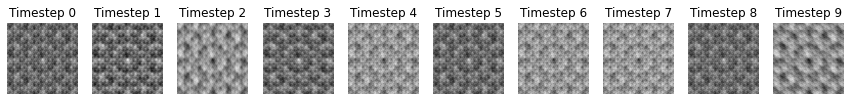

In [11]:
neural_image_df = pd.DataFrame(neural_image_df.copy())
n = 10
# Get the first n rows from the DataFrame
first_n_images = neural_image_df.iloc[:n]
# Create a figure and axis objects
fig, axes = plt.subplots(1, n, figsize=(15, 15))

# Loop through each row and plot the image
for i, (index, row) in enumerate(first_n_images.iterrows()):
    # Reshape the row to 250x250
    image_data = row.values.reshape(250, 250)
    
    # Plot the image
    ax = axes[i]
    ax.imshow(image_data, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Timestep {index}')

plt.show()

## 3) Try neural images with images with other images.

In [15]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name']=='natural_scenes']

# Pull from where images are located.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# Show all scenes.
scene_nums = np.arange(0)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')
# Initialize an empty list to store the flattened grayscale arrays
flattened_scenes = []

# Loop through each image and flatten it
for i in range(scenes.shape[0]):
    flattened_image = scenes[i].flatten()
    flattened_scenes.append(flattened_image)

# Convert the list of 1D arrays to a DataFrame
flattened_natural_scenes_df = pd.DataFrame(flattened_scenes)
flattened_natural_scenes_df

,0,1,2,3,4,5,6,7,8,9,...,1077722,1077723,1077724,1077725,1077726,1077727,1077728,1077729,1077730,1077731
0,165.0,165.0,165.0,161.0,161.0,161.0,161.0,157.0,157.0,157.0,...,253.0,253.0,253.0,253.0,231.0,231.0,231.0,231.0,244.0,244.0
1,77.0,77.0,77.0,74.0,74.0,74.0,74.0,92.0,92.0,92.0,...,60.0,60.0,60.0,60.0,47.0,47.0,47.0,47.0,51.0,51.0
2,193.0,193.0,193.0,191.0,191.0,191.0,191.0,188.0,188.0,188.0,...,206.0,206.0,206.0,206.0,211.0,211.0,211.0,211.0,211.0,211.0
3,37.0,37.0,37.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,...,94.0,94.0,94.0,94.0,134.0,134.0,134.0,134.0,128.0,128.0
4,62.0,62.0,62.0,66.0,66.0,66.0,66.0,68.0,68.0,68.0,...,16.0,16.0,16.0,16.0,38.0,38.0,38.0,38.0,49.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,100.0,91.0,91.0,91.0,93.0,93.0,109.0,109.0,109.0,125.0
114,238.0,238.0,251.0,251.0,251.0,246.0,246.0,229.0,229.0,229.0,...,93.0,91.0,91.0,91.0,90.0,90.0,85.0,85.0,85.0,90.0
115,64.0,64.0,64.0,64.0,64.0,62.0,62.0,63.0,63.0,63.0,...,82.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0
116,21.0,21.0,29.0,29.0,29.0,24.0,24.0,19.0,19.0,19.0,...,12.0,18.0,18.0,18.0,19.0,19.0,21.0,21.0,21.0,29.0


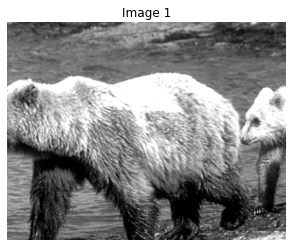

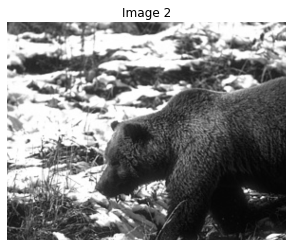

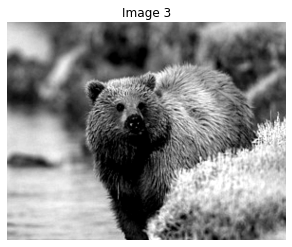

In [16]:
# Function to display the first n images from the DataFrame
def display_first_n_images(df, n, original_shape):
    for i in range(min(n, len(df))):
        image_array = np.array(df.iloc[i]).reshape(original_shape)
        plt.imshow(image_array, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')
        plt.show()

# Original shape of the natural scenes
original_shape = (918, 1174)

# Display the first 5 images
display_first_n_images(flattened_natural_scenes_df, 3, original_shape)

In [17]:
frames = np.array(filtered_normalized_firing_rates.iloc[:,0]).astype(int)

# Pre-allocate DataFrame
n_rows = len(frames)
n_cols = flattened_natural_scenes_df.shape[1]
repeated_images_df = pd.DataFrame(np.zeros((n_rows, n_cols)), columns=flattened_natural_scenes_df.columns)

# Populate the DataFrame
for i, frame in enumerate(frames):
    repeated_images_df.iloc[i] = flattened_natural_scenes_df.iloc[frame]

# If you want to reset the index
repeated_images_df.reset_index(drop=True, inplace=True)
np.shape(repeated_images_df)

(5950, 1077732)

In [18]:
R_it = repeated_images_df
S_tp = filtered_normalized_firing_rates.iloc[:,1:]
print(f"R_it shape: {R_it.shape}")
print(f"S_tp shape: {S_tp.shape}")

R_it shape: (5950, 1077732)
S_tp shape: (5950, 1171)


In [19]:
# Save the DataFrame to a pickle file
R_it.to_pickle('R_it.pkl')
S_tp.to_pickle('S_tp.pkl')

In [5]:
# Read the DataFrame from a pickle file
R_it = pd.read_pickle('R_it.pkl')
S_tp = pd.read_pickle('S_tp.pkl')


In [6]:
from sklearn.model_selection import train_test_split
frames = np.array(filtered_normalized_firing_rates.iloc[:,0]).astype(int)
# Convert frames to a Pandas Series
frames_series = pd.Series(frames)

# Let's say these are the 10 frames you want to keep for testing
test_frames = np.arange(10)  # Replace these with the actual frame numbers you want to keep for testing

# Create masks for selecting rows
test_mask = frames_series.isin(test_frames)
train_mask = ~frames_series.isin(test_frames)

# Create training and test sets for R_it and S_tp
R_it_train = R_it[train_mask]
R_it_test = R_it[test_mask]

S_tp_train = S_tp[train_mask]
S_tp_test = S_tp[test_mask]

# Print the shapes
print(f"R_it_train shape: {R_it_train.shape}")
print(f"R_it_test shape: {R_it_test.shape}")
print(f"S_tp_train shape: {S_tp_train.shape}")
print(f"S_tp_test shape: {S_tp_test.shape}")

R_it_train shape: (5450, 1077732)
R_it_test shape: (500, 1077732)
S_tp_train shape: (5450, 1171)
S_tp_test shape: (500, 1171)


In [8]:
import torch
import pandas as pd
import gc
from tqdm import tqdm

def batch_mm(A, B, batch_size=1000):
    result = []
    for i in tqdm(range(0, A.shape[0], batch_size), desc="Batch Processing"):
        end = i + batch_size if i + batch_size < A.shape[0] else A.shape[0]
        batch_result = torch.mm(A[i:end, :], B)
        result.append(batch_result)
        del batch_result  # Explicitly delete the variable
        gc.collect()  # Run garbage collection
    return torch.cat(result, dim=0)

# Convert your pandas DataFrame to PyTorch tensors
R_it_train_tensor = torch.tensor(R_it_train.values, dtype=torch.float32)
S_tp_train_tensor = torch.tensor(S_tp_train.values, dtype=torch.float32)
R_it_test_tensor = torch.tensor(R_it_test.values, dtype=torch.float32)

In [ ]:
# Step 1: Calculate the preferred stimulus for each neuron
print("Calculating preferred stimulus...")
preferred_stimulus = batch_mm(R_it_train_tensor.t(), S_tp_train_tensor)
torch.save(preferred_stimulus, 'preferred_stimulus.pt')  # Save the tensor to disk
del preferred_stimulus  # Delete to free memory
gc.collect()  # Run garbage collection

Calculating preferred stimulus...


Batch Processing: 100%|██████████| 1078/1078 [10:16<00:00,  1.75it/s]


In [ ]:
# Step 1: Calculate the preferred stimulus for each neuron
print("Calculating preferred stimulus...")
preferred_stimulus = batch_mm(R_it_train_tensor.t(), S_tp_train_tensor)
torch.save(preferred_stimulus, 'preferred_stimulus.pt')  # Save the tensor to disk
del preferred_stimulus  # Delete to free memory
gc.collect()  # Run garbage collection

# Load the tensor back when needed
preferred_stimulus = torch.load('preferred_stimulus.pt')


# Step 2: Calculate the neural images for the test set
print("Calculating neural images for the test set...")
neural_images_test = batch_mm(R_it_test_tensor, preferred_stimulus)

# Convert the result back to a DataFrame
preferred_stimulus_df = pd.DataFrame(preferred_stimulus.numpy(), columns=S_tp_train.columns)
neural_images_test_df = pd.DataFrame(neural_images_test.numpy(), columns=S_tp_train.columns)

# Print the shapes
print(f"Preferred stimulus shape: {preferred_stimulus_df.shape}")
print(f"Neural images test shape: {neural_images_test_df.shape}")

In [ ]:
import torch
import pandas as pd

# Convert your pandas DataFrame to PyTorch tensors
R_it_train_tensor = torch.tensor(R_it_train.values, dtype=torch.float32)
S_tp_train_tensor = torch.tensor(S_tp_train.values, dtype=torch.float32)
R_it_test_tensor = torch.tensor(R_it_test.values, dtype=torch.float32)

# Step 1: Calculate the preferred stimulus for each neuron
preferred_stimulus = torch.mm(R_it_train_tensor.t(), S_tp_train_tensor)

# Step 2: Calculate the neural images for the test set
neural_images_test = torch.mm(R_it_test_tensor, preferred_stimulus)

# Convert the result back to a DataFrame
preferred_stimulus_df = pd.DataFrame(preferred_stimulus.numpy(), columns=S_tp_train.columns)
neural_images_test_df = pd.DataFrame(neural_images_test.numpy(), columns=S_tp_train.columns)

# Print the shapes
print(f"Preferred stimulus shape: {preferred_stimulus_df.shape}")
print(f"Neural images test shape: {neural_images_test_df.shape}")

In [15]:
import pandas as pd
import numpy as np

# Step 1: Calculate the preferred stimulus using the training set
# Initialize an empty DataFrame to store the preferred stimulus for each neuron
preferred_stimulus = pd.DataFrame(columns=S_tp_train.columns)

# Calculate the preferred stimulus using matrix multiplication
preferred_stimulus = R_it_train.T @ S_tp_train

# Step 2: Calculate the neural images using the test set
# Initialize an empty DataFrame to store the neural images
neural_images_test = pd.DataFrame(columns=S_tp_test.columns)

# Calculate the neural images using matrix multiplication
neural_images_test = R_it_test @ preferred_stimulus

# Print the shapes
print(f"Preferred stimulus shape: {preferred_stimulus.shape}")
print(f"Neural images test shape: {neural_images_test.shape}")

KeyboardInterrupt: 

In [17]:
# Step 1: Calculate the preferred stimulus using the training set
# Initialize an empty DataFrame to store the preferred stimulus for each neuron
preferred_stimulus = pd.DataFrame(columns=S_tp_train.columns)

# Calculate the preferred stimulus using matrix multiplication
preferred_stimulus = R_it_train.T @ S_tp_train


KeyboardInterrupt: 

In [ ]:
import numpy as np

# Convert DataFrames to NumPy arrays for faster computation
R_it_train_np = R_it_train.to_numpy()
S_tp_train_np = S_tp_train.to_numpy()
R_it_test_np = R_it_test.to_numpy()

# Step 1: Calculate the preferred stimulus using the training set
# Use NumPy's dot product for faster matrix multiplication
preferred_stimulus_np = np.dot(R_it_train_np.T, S_tp_train_np)

# Step 2: Calculate the neural images using the test set
# Use NumPy's dot product for faster matrix multiplication
neural_images_test_np = np.dot(R_it_test_np, preferred_stimulus_np)

# Convert the resulting NumPy arrays back to DataFrames if needed
preferred_stimulus = pd.DataFrame(preferred_stimulus_np, columns=S_tp_train.columns)
neural_images_test = pd.DataFrame(neural_images_test_np, columns=S_tp_test.columns)

# Print the shapes
print(f"Preferred stimulus shape: {preferred_stimulus.shape}")
print(f"Neural images test shape: {neural_images_test.shape}")


# Neural Encoding articles, finish reading

- https://arxiv.org/abs/2307.10246
- https://arxiv.org/abs/2307.10246
- https://www.nature.com/articles/s41467-023-41261-2
- https://www.nature.com/articles/s41467-023-39520-3
- https://www.nature.com/articles/s42254-022-00430-w